# Projet de Machine Learning  UMONS 2024-2025

### Thème : Prédiction du score de Macron aux 2nd Tour des éléctions 2022

----

# Configuration et Installation des Dépendances

## a. Import des Bibliothèques/dépendances


In [5]:
# @title manipulation des vecteurs
import pandas as pd
import numpy as np


In [6]:
# @title création des graphiques
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick


In [7]:
# @title prétraitement des données en masse
from sklearn.preprocessing import OneHotEncoder, RobustScaler , FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


In [8]:
# @title selection des features
from sklearn.feature_selection import VarianceThreshold


In [9]:
# @title sélection du meilleur modèle
import optuna
from sklearn.model_selection import train_test_split, KFold, cross_val_score , RepeatedKFold

In [10]:
# @title fonction de score et evaluation
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score ,mean_absolute_error

In [11]:
# @title initialisation des modèles
from sklearn.linear_model import ElasticNet, LassoCV, Ridge , Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor


In [12]:
# @title options sytèmes
from sys import modules as sys_modules
import os
import sys
import joblib
import warnings
import os
import glob
import re
from IPython.display import Markdown, display




## b. Configuration


In [13]:
#Pour ignorer les warnings
warnings.filterwarnings('ignore')

# configuration des graphiques
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette('Set2')

# Pour une meilleure lisibilité dans le notebook
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', '{:.3f}'.format)

print("chargement des bibliothèques terminé")

chargement des bibliothèques terminé


# Constantes

In [126]:
# @title Paramètres globaux
CORRTHRESHOLD = 60 # @param {"type":"integer"}
RANDOM_STATE = 42 # @param {"type":"integer"}
IDs= [] # @param {type:"raw"}

# Fonctions utilitaires

In [127]:
# @title Utilitaires

def sep(lg=180):
    """Affiche une ligne de séparation"""
    print("\n" + "-"*lg + "\n")

def sub(l1,l2):
  """Retourne la liste des éléments de l1 qui ne sont pas dans l2"""
  return [x for x in l1 if x not in l2]


In [ ]:
def get_columns_above_missing_threshold(df, threshold:int=CORRTHRESHOLD):
    """
    Identifie les colonnes ayant un pourcentage de valeurs manquantes supérieur au seuil spécifié.

    Args:
        df (pandas.DataFrame): Le DataFrame à analyser
        threshold (float): Le seuil en pourcentage (entre 0 et 100) au-delà duquel une colonne est considérée
                          comme ayant trop de valeurs manquantes. Par défaut : 50

    Returns:
        list: Liste des noms de colonnes dont le pourcentage de valeurs manquantes dépasse le seuil,
              triée par pourcentage décroissant
    """
    # Vérification que le seuil est valide
    if not 0 <= threshold <= 100:
        raise ValueError("Le seuil doit être compris entre 0 et 100")

    # Calcul du pourcentage de valeurs manquantes par colonne
    missing_percentages = (df.isnull().sum() / len(df)) * 100

    # Sélection des colonnes dépassant le seuil
    columns_above_threshold = missing_percentages[missing_percentages > threshold]

    # Tri par pourcentage décroissant
    columns_above_threshold = columns_above_threshold.sort_values(ascending=False)

    # Création d'un DataFrame avec les colonnes et leurs pourcentages
    """result_df = pd.DataFrame({
        'Colonne': columns_above_threshold.index,
        'Pourcentage de valeurs manquantes': columns_above_threshold.values
    })"""

    return  columns_above_threshold.index.to_list() , pd.DataFrame(columns_above_threshold)

def visualise(df):
  print(f"forme : {df.shape}")
  sep()

def all_columns(df, res=True):
  all_col = df.columns.tolist()
  print(f"les colonnes sont : \n{df.columns}")
  sep()
  print(f" il y'a {len(all_col)} colonnes dans le dataframe")
  sep()
  if res:
    return all_col
  else:
    return None

def get_analyse(data , id , col_to_drop , res =True):

    df= data.copy()
    all_col = df.columns.tolist()
    col_to_keep = sub(all_col,col_to_drop)
    to_holes,_ = get_columns_above_missing_threshold(df[col_to_keep])
    col_to_keep2 = sub(col_to_keep,to_holes)
    IDs.append(id)
    print(f"colonne identifiant : '{id}' ")
    sep()
    print(f" colonnes avec > {CORRTHRESHOLD} % de valeurs manquantes \n{to_holes}")
    sep()
    print(f"les colonnes à supprimer sont :\n{col_to_drop}  \net  {to_holes} ")
    sep()
    print(f"\non conserve les colonnes  :\n{col_to_keep2} ")
    sep()
    if res:
      return col_to_keep2 , to_holes
    else:
      return None

def write_markdown_conclusion(id_colonne, colonnes_manquantes, colonnes_supprimer, colonnes_conserver):
    """
    Génère une section Markdown pour la conclusion de l'analyse d'un DataFrame.

    Args:
        id_colonne (str): Nom de la colonne d'identification.
        colonnes_manquantes (list): Liste des colonnes avec un fort taux de valeurs manquantes.
        colonnes_supprimer (list): Liste des colonnes à supprimer.
        colonnes_conserver (list): Liste des colonnes à conserver.
    """

    markdown_text = f"""
#### Conclusion

* _Identifiant_ : ``'{id_colonne}'``

* _Colonnes avec plus de {CORRTHRESHOLD}% de valeurs manquantes_ : ``{colonnes_manquantes}``

* _Colonnes à supprimer_ : ``{colonnes_supprimer}``

* _Colonnes à conserver_ : ``{colonnes_conserver}``

----
"""
    display(Markdown(markdown_text))


In [129]:
def display_correlation_matrix(df , save = False,name=None):
    """
    Affiche la matrice de corrélation entre les colonnes numériques du DataFrame et la colonne cible.

    Args:
    ----
    df : pd.DataFrame
        Le DataFrame à analyser.
    target : str
        Le nom de la colonne cible.
    threshold : float
        Le seuil de corrélation au-delà duquel les colonnes sont considérées comme corrélées.
    """
    num_cols = df.select_dtypes(include=[np.number]).columns
    # Calculer la matrice de corrélation
    corr_matrix = df[num_cols].corr()

    # Masquer la moitié inférieure
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Afficher la matrice de corrélation
    fig = plt.figure(figsize=(12, 8))
    sns.heatmap(upper, annot=True, fmt=".2f", cmap='coolwarm', square=True)
    plt.title("Matrice de corrélation")
    plt.tight_layout()
    if save:
        if name is None:
            plt.savefig("corr_matrix.png")
        else:
            plt.savefig(f"corr_matrix_{name}.png")
    plt.show()



# 1. EXPLORATION DES DONNEES


Le but ici c'est d'essayer de comprendre  les données , c'est pouvoir repondre aux questions :
* Quelles sont les données visiblement non-pertinentes ?
* Detecter les outliers ?
* Vérifier le taux de valeurs manquantes
* regrouper les informations en indices synthétiques

----

## 1.1 Chargement des données

In [17]:
# @title chemin vers le dossier dataset : dossier contenant toute les données à utiliser
if 'google.colab' in sys_modules :
  from google.colab import drive
  drive.mount('/content/drive')
  data_path = "/content/drive/MyDrive/Colab_Notebooks/ProjetML/src/datasets"
else:
  data_path = "datasets"

print("debut du chargement des données ... .. ... ..")

debut du chargement des données ... .. ... ..


In [18]:
# @title Chargement des données de d'entrainement et de test
result_train = pd.read_csv( os.path.join(data_path,"results_train.csv") , sep = ',',encoding='utf-8')
result_test = pd.read_csv( os.path.join(data_path,"results_test.csv") , sep = ',',encoding='utf-8')

res_train_df = result_train.copy()
res_test_df = result_test.copy()

#### Données additionnelles

In [19]:
# @title Niveau de vie
niveau_vie = pd.read_excel(os.path.join(data_path, "Niveau_de_vie_2013_a_la_commune.xlsx"))
niveau_vie_df = niveau_vie.copy()

In [20]:
# @title Communes de France
communes_france = pd.read_csv(os.path.join(data_path, "communes-france-2022.csv"), sep=',', encoding='utf-8')
communes_df = communes_france.copy()

In [21]:
# @title Données d'âge
age_insee = pd.read_excel(os.path.join(data_path, "age-insee-2020.xlsx"))
age_df = age_insee.copy()

In [22]:
# @title Données diverses INSEE
insee_divers = pd.read_excel(os.path.join(data_path, "MDB-INSEE-V2.xls"))
insee_divers_df = insee_divers.copy()

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


In [23]:
print("chargement des données terminé !! ")

chargement des données terminé !! 


## 1.2 Pré-Analyse  et Pré-Selection(visuelle) des Features (colonnes)

In [228]:
# @title colonne cible
target = '% Voix/Ins' # @param {type:"string"}

### results_train

In [229]:
# @title visualisation
visualise(res_train_df)

res_train_df.head(3)

forme : (20892, 32)

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------



,CodeINSEE,Libellé du département,Libellé de la commune,Etat saisie,Inscrits,Abstentions,% Abs/Ins,Votants,% Vot/Ins,Blancs,% Blancs/Ins,% Blancs/Vot,Nuls,% Nuls/Ins,% Nuls/Vot,Exprimés,% Exp/Ins,% Exp/Vot,N°Panneau,Sexe,Nom,Prénom,Voix,% Voix/Ins,% Voix/Exp,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32
0,01006,Ain,Ambléon,Complet,103,19,18.450,84,81.550,12,11.650,14.290,0,0.000,0.000,72,69.900,85.710,1,M,MACRON,Emmanuel,45,43.690,62.500,2,F,LE PEN,Marine,27,26.210,37.500
1,01009,Ain,Andert-et-Condon,Complet,280,73,26.070,207,73.930,22,7.860,10.630,3,1.070,1.450,182,65.000,87.920,1,M,MACRON,Emmanuel,102,36.430,56.040,2,F,LE PEN,Marine,80,28.570,43.960
2,01010,Ain,Anglefort,Complet,792,185,23.360,607,76.640,31,3.910,5.110,8,1.010,1.320,568,71.720,93.570,1,M,MACRON,Emmanuel,227,28.660,39.960,2,F,LE PEN,Marine,341,43.060,60.040


In [230]:
# @title affichage des colonnes
all_col_train = all_columns(res_train_df)

les colonnes sont : 
Index(['CodeINSEE', 'Libellé du département', 'Libellé de la commune',
       'Etat saisie', 'Inscrits', 'Abstentions', '% Abs/Ins', 'Votants',
       '% Vot/Ins', 'Blancs', '% Blancs/Ins', '% Blancs/Vot', 'Nuls',
       '% Nuls/Ins', '% Nuls/Vot', 'Exprimés', '% Exp/Ins', '% Exp/Vot',
       'N°Panneau', 'Sexe', 'Nom', 'Prénom', 'Voix', '% Voix/Ins',
       '% Voix/Exp', 'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28',
       'Unnamed: 29', 'Unnamed: 30', 'Unnamed: 31', 'Unnamed: 32'],
      dtype='object')

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

 il y'a 32 colonnes dans le dataframe

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------



In [231]:
# @title présélection
# colonnes clairement non informatives à supprimer
col_to_drop_train = ['Unnamed: 27' ,'Unnamed: 26' , 'Unnamed: 28' ,
                'Unnamed: 29' , 'Unnamed: 30','Unnamed: 31' ,
                'Unnamed: 32' ,'Prénom','Sexe','Nom','N°Panneau']

id_train = 'CodeINSEE'

col_to_keep1 , to_holes_train = get_analyse(res_train_df,id_train,col_to_drop_train)

colonne identifiant : 'CodeINSEE' 

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

 colonnes avec > 60 % de valeurs manquantes 
[]

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

les colonnes à supprimer sont :
['Unnamed: 27', 'Unnamed: 26', 'Unnamed: 28', 'Unnamed: 29', 'Unnamed: 30', 'Unnamed: 31', 'Unnamed: 32', 'Prénom', 'Sexe', 'Nom', 'N°Panneau']  
et  [] 

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


on conserve les colonnes  :
['CodeINSEE', 'Libellé du département', 'Libellé de la commune', 'Etat saisie', 'Inscrits', 'Abstentions', '% Abs/Ins', 'Votants', '% Vot/Ins', 'Blancs',

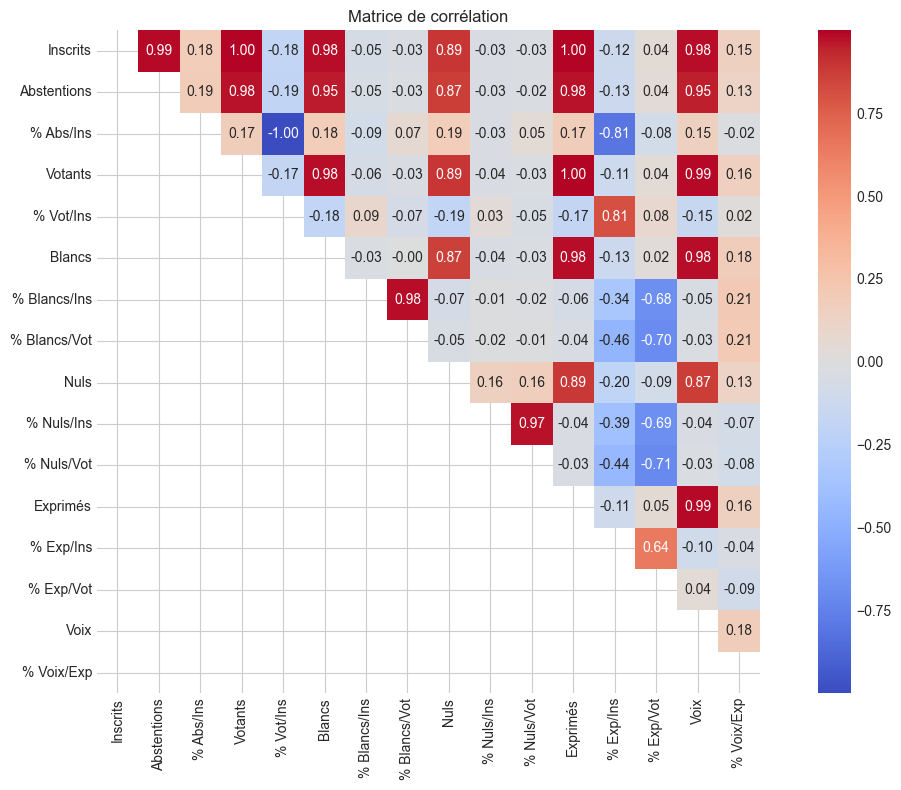

In [232]:
data_corr = res_train_df.copy()
data_corr = data_corr.drop(columns=col_to_drop_train, axis=1,errors='ignore')
data_corr = data_corr.drop(columns=target, axis=1,errors='ignore')

display_correlation_matrix(data_corr, save = True , name="result_train")

In [233]:
# @title conclusion
write_markdown_conclusion(id_train, to_holes_train, col_to_drop_train, col_to_keep1)


#### Conclusion

* _Identifiant_ : ``'CodeINSEE'``

* _Colonnes avec plus de 60% de valeurs manquantes_ : ``[]``

* _Colonnes à supprimer_ : ``['Unnamed: 27', 'Unnamed: 26', 'Unnamed: 28', 'Unnamed: 29', 'Unnamed: 30', 'Unnamed: 31', 'Unnamed: 32', 'Prénom', 'Sexe', 'Nom', 'N°Panneau']``

* _Colonnes à conserver_ : ``['CodeINSEE', 'Libellé du département', 'Libellé de la commune', 'Etat saisie', 'Inscrits', 'Abstentions', '% Abs/Ins', 'Votants', '% Vot/Ins', 'Blancs', '% Blancs/Ins', '% Blancs/Vot', 'Nuls', '% Nuls/Ins', '% Nuls/Vot', 'Exprimés', '% Exp/Ins', '% Exp/Vot', 'Voix', '% Voix/Ins', '% Voix/Exp']``

----


### niveau de vie

In [234]:
# @title visualisation
visualise(niveau_vie_df)

niveau_vie_df.head(50)

forme : (36572, 4)

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------



,Code Commune,Nom Commune,Niveau de vie Commune,Niveau de vie Département
0,05047,Éourres,10021.250,19202.516
1,26142,Glandage,10215.000,19300.504
2,11317,Rodome,10908.500,17599.733
3,11384,Soulatgé,11485.167,17599.733
4,30153,Malons-et-Elze,11680.000,18282.544
5,13203,Marseille 3e Arrondissement,11760.800,20006.785
6,26055,Boulc,11903.214,19300.504
7,09118,Esplas-de-Sérou,12074.000,18463.189
8,11346,Saint-Jean-de-Paracol,12173.333,17599.733
9,09231,Le Port,12193.000,18463.189


In [235]:
all_col_niveau_vie = all_columns(niveau_vie_df)


les colonnes sont : 
Index(['Code Commune', 'Nom Commune', 'Niveau de vie Commune',
       'Niveau de vie Département'],
      dtype='object')

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

 il y'a 4 colonnes dans le dataframe

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------



In [236]:
# @title présélection
# colonnes clairement non informatives à supprimer
col_to_drop_niveau = []
id_niveau = 'Code Commune'

col_to_keep2 , to_holes_niveau = get_analyse(niveau_vie_df,id_niveau,col_to_drop_niveau)

colonne identifiant : 'Code Commune' 

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

 colonnes avec > 60 % de valeurs manquantes 
[]

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

les colonnes à supprimer sont :
[]  
et  [] 

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


on conserve les colonnes  :
['Code Commune', 'Nom Commune', 'Niveau de vie Commune', 'Niveau de vie Département'] 

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------



In [237]:
# @title conclusion
write_markdown_conclusion(id_niveau, to_holes_niveau, col_to_drop_niveau, col_to_keep2)


#### Conclusion

* _Identifiant_ : ``'Code Commune'``

* _Colonnes avec plus de 60% de valeurs manquantes_ : ``[]``

* _Colonnes à supprimer_ : ``[]``

* _Colonnes à conserver_ : ``['Code Commune', 'Nom Commune', 'Niveau de vie Commune', 'Niveau de vie Département']``

----


### communes de frances

In [238]:
# @title visualisation
visualise(communes_df)

communes_df.head(100)

forme : (35010, 39)

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------



,Unnamed: 0,code_insee,nom_standard,nom_sans_pronom,nom_a,nom_de,nom_sans_accent,nom_standard_majuscule,typecom,typecom_texte,reg_code,reg_nom,dep_code,dep_nom,canton_code,canton_nom,epci_code,epci_nom,academie_code,academie_nom,code_postal,codes_postaux,zone_emploi,code_insee_centre_zone_emploi,population,superficie_hectare,superficie_km2,densite,altitude_moyenne,altitude_minimale,altitude_maximale,latitude_mairie,longitude_mairie,latitude_centre,longitude_centre,grille_densite,gentile,url_wikipedia,url_villedereve
0,0,01001,L'Abergement-Clémenciat,Abergement-Clémenciat,à Abergement-Clémenciat,de l'Abergement-Clémenciat,l-abergement-clemenciat,L'ABERGEMENT-CLÉMENCIAT,COM,commune,84,Auvergne-Rhône-Alpes,01,Ain,0108,Châtillon-sur-Chalaronne,200069193,CC de la Dombes,10,Lyon,1400,01400,8405.000,01053,779,1565,16,48.700,242,206.000,272.000,46.153,4.926,46.153,4.926,Rural à habitat dispersé,NaN,https://fr.wikipedia.org/wiki/fr:L'Abergement-...,https://villedereve.fr/ville/01001-l-abergemen...
1,1,01002,L'Abergement-de-Varey,Abergement-de-Varey,à Abergement-de-Varey,de l'Abergement-de-Varey,l-abergement-de-varey,L'ABERGEMENT-DE-VAREY,COM,commune,84,Auvergne-Rhône-Alpes,01,Ain,0101,Ambérieu-en-Bugey,240100883,CC de la Plaine de l'Ain,10,Lyon,1640,01640,8405.000,01053,256,912,9,27.100,483,290.000,748.000,46.009,5.428,46.009,5.428,Rural à habitat dispersé,"Abergementais, Abergementaises",https://fr.wikipedia.org/wiki/fr:L'Abergement-...,https://villedereve.fr/ville/01002-l-abergemen...
2,2,01004,Ambérieu-en-Bugey,Ambérieu-en-Bugey,à Ambérieu-en-Bugey,d'Ambérieu-en-Bugey,amberieu-en-bugey,AMBÉRIEU-EN-BUGEY,COM,commune,84,Auvergne-Rhône-Alpes,01,Ain,0101,Ambérieu-en-Bugey,240100883,CC de la Plaine de l'Ain,10,Lyon,1500,"01500, 01501, 01504, 01503, 01502, 01505, 01506",8405.000,01053,14134,2448,24,570.500,379,237.000,753.000,45.961,5.373,45.961,5.373,Centres urbains intermédiaires,"Ambarrois, Ambarroises",https://fr.wikipedia.org/wiki/fr:Ambérieu-en-B...,https://villedereve.fr/ville/01004-amberieu-en...
3,3,01005,Ambérieux-en-Dombes,Ambérieux-en-Dombes,à Ambérieux-en-Dombes,d'Ambérieux-en-Dombes,amberieux-en-dombes,AMBÉRIEUX-EN-DOMBES,COM,commune,84,Auvergne-Rhône-Alpes,01,Ain,0122,Villars-les-Dombes,200042497,CC Dombes Saône Vallée,10,Lyon,1330,01330,8434.000,69264,1751,1605,16,106.100,290,265.000,302.000,45.996,4.912,45.996,4.912,Bourgs ruraux,Ambarrois,https://fr.wikipedia.org/wiki/fr:Ambérieux-en-...,https://villedereve.fr/ville/01005-amberieux-e...
4,4,01006,Ambléon,Ambléon,à Ambléon,d'Ambléon,ambleon,AMBLÉON,COM,commune,84,Auvergne-Rhône-Alpes,01,Ain,0104,Belley,200040350,CC Bugey Sud,10,Lyon,1300,01300,8404.000,01034,112,602,6,18.900,589,330.000,940.000,45.750,5.594,45.750,5.594,Rural à habitat dispersé,Ambléonais,https://fr.wikipedia.org/wiki/fr:Ambléon,https://villedereve.fr/ville/01006-ambleon
5,5,01007,Ambronay,Ambronay,à Ambronay,d'Ambronay,ambronay,AMBRONAY,COM,commune,84,Auvergne-Rhône-Alpes,01,Ain,0101,Ambérieu-en-Bugey,240100883,CC de la Plaine de l'Ain,10,Lyon,1500,"01500, 01504",8405.000,01053,2800,3359,34,81.300,309,225.000,765.000,46.006,5.358,46.006,5.358,Rural à habitat dispersé,Ambrons,https://fr.wikipedia.org/wiki/fr:Ambronay,https://villedereve.fr/ville/01007-ambronay
6,6,01008,Ambutrix,Ambutrix,à Ambutrix,d'Ambutrix,ambutrix,AMBUTRIX,COM,commune,84,Auvergne-Rhône-Alpes,01,Ain,0101,Ambérieu-en-Bugey,240100883,CC de la Plaine de l'Ain,10,Lyon,1500,01500,8405.000,01053,762,518,5,144.100,274,237.000,370.000,45.937,5.333,45.937,5.333,Ceintures urbaines,Butrians,https://fr.wikipedia.org/wiki/fr:Ambutrix,https://villedereve.fr/ville/01008-ambutrix
7,7,01009,Andert-et-Condon,Andert-et-Condon,à Andert-et-Condon,d'Andert-et-Condon,andert-et-condon,ANDERT-ET-CONDON,COM,commune,84,Auvergne-Rhône-Alpes,01,Ain,0104,Belley,200040350,CC Bugey Sud,10,Lyon,1300,01300,8404.000,01034,326,696,7,47.600,294,225.000,374.000,45.787,5.658,45.787,5.658,Rural à habitat dispersé,NaN,https://fr.wikipedia.org/wiki/fr:Andert-et-Condon,https://

In [239]:
# @title all colonnes
all_col_commune = all_columns(communes_df)

les colonnes sont : 
Index(['Unnamed: 0', 'code_insee', 'nom_standard', 'nom_sans_pronom', 'nom_a',
       'nom_de', 'nom_sans_accent', 'nom_standard_majuscule', 'typecom',
       'typecom_texte', 'reg_code', 'reg_nom', 'dep_code', 'dep_nom',
       'canton_code', 'canton_nom', 'epci_code', 'epci_nom', 'academie_code',
       'academie_nom', 'code_postal', 'codes_postaux', 'zone_emploi',
       'code_insee_centre_zone_emploi', 'population', 'superficie_hectare',
       'superficie_km2', 'densite', 'altitude_moyenne', 'altitude_minimale',
       'altitude_maximale', 'latitude_mairie', 'longitude_mairie',
       'latitude_centre', 'longitude_centre', 'grille_densite', 'gentile',
       'url_wikipedia', 'url_villedereve'],
      dtype='object')

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

 il y'a 39 colonnes dans le dataframe

--------------------------

A première vu , on n'a pas besoin des
* url vers les sites internet des communes  c'est à dire ``url_wikipedia`` , ``url_ville``
* ``typecom`` et ``typecom_texte`` sont des colonnes constantes : on est toujours censé avoir à faire à des communes
* pas besoin de tous les type de noms de la communes , un seul suffira `nom_standard` , mais il est aussi renseigné dans `Niveau de vie`
* unamed ici represente un index donc inutile aussi
* on peut regrouper ` 'altitude_moyenne'`, `'altitude_minimale'`,
       `'altitude_maximale'` en  un ou deux indices d'altitude , idem pour les ``latitude...`` et ``longitute...``
* supprimer les infos d'identification (x_code , x_nom) sur les départements et régions , leurs codes sont déjà fourni dans ``MDB-insee-divers`` ce dernier ayant plus d'échantillons

In [240]:
# @title présélection
# colonnes clairement non informatives à supprimer
"""
col_to_drop_commune = ['url_wikipedia','url_villedereve',
                       'typecom','typecom_texte',
                       'nom_standard','nom_a','nom_de',
                       'nom_sans_accent','nom_standard_majuscule',
                       'superficie_hectare','Unnamed: 0',
                       'reg_code', 'reg_nom', 'dep_code', 'dep_nom']"""
col_to_drop_commune = ['url_wikipedia','url_villedereve',
                       'typecom','typecom_texte',
                       'nom_standard','nom_a','nom_de',
                       'nom_sans_pronom','gentile',
                       'nom_sans_accent','nom_standard_majuscule',
                       'superficie_hectare','Unnamed: 0',
                       'academie_nom','codes postaux',
                       'longitude_centre','latitude_centre',
                       'reg_nom','dep_nom','canton_nom','epci_nom']
id_commune = 'code_insee'

col_to_keep3 , to_holes_commune = get_analyse(communes_df,id_commune,col_to_drop_commune)

colonne identifiant : 'code_insee' 

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

 colonnes avec > 60 % de valeurs manquantes 
[]

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

les colonnes à supprimer sont :
['url_wikipedia', 'url_villedereve', 'typecom', 'typecom_texte', 'nom_standard', 'nom_a', 'nom_de', 'nom_sans_pronom', 'gentile', 'nom_sans_accent', 'nom_standard_majuscule', 'superficie_hectare', 'Unnamed: 0', 'academie_nom', 'codes postaux', 'longitude_centre', 'latitude_centre', 'reg_nom', 'dep_nom', 'canton_nom', 'epci_nom']  
et  [] 

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [241]:
# @title conclusion
write_markdown_conclusion(id_commune, to_holes_commune, col_to_drop_commune, col_to_keep3)


#### Conclusion

* _Identifiant_ : ``'code_insee'``

* _Colonnes avec plus de 60% de valeurs manquantes_ : ``[]``

* _Colonnes à supprimer_ : ``['url_wikipedia', 'url_villedereve', 'typecom', 'typecom_texte', 'nom_standard', 'nom_a', 'nom_de', 'nom_sans_pronom', 'gentile', 'nom_sans_accent', 'nom_standard_majuscule', 'superficie_hectare', 'Unnamed: 0', 'academie_nom', 'codes postaux', 'longitude_centre', 'latitude_centre', 'reg_nom', 'dep_nom', 'canton_nom', 'epci_nom']``

* _Colonnes à conserver_ : ``['code_insee', 'reg_code', 'dep_code', 'canton_code', 'epci_code', 'academie_code', 'code_postal', 'codes_postaux', 'zone_emploi', 'code_insee_centre_zone_emploi', 'population', 'superficie_km2', 'densite', 'altitude_moyenne', 'altitude_minimale', 'altitude_maximale', 'latitude_mairie', 'longitude_mairie', 'grille_densite']``

----


### age-insee

In [242]:
# @title visualisation
visualise(age_df)

age_df.head(3)

forme : (34980, 26)

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------



,INSEE,NOM,EPCI,DEP,REG,F0-2,F3-5,F6-10,F11-17,F18-24,F25-39,F40-54,F55-64,F65-79,F80+,Unnamed: 15,H0-2,H3-5,H6-10,H11-17,H18-24,H25-39,H40-54,H55-64,H65-79,H80+
0,1001,L'Abergement-Clémenciat,200069193,D1,R84,13.414,12.509,19.214,37.182,14.062,70.119,84.512,60.032,64.311,20.164,NaN,18.070,14.403,34.540,40.257,14.231,72.498,81.849,61.039,55.240,18.353
1,1002,L'Abergement-de-Varey,240100883,D1,R84,2.994,6.050,12.232,11.869,5.202,20.498,33.975,12.365,12.419,7.027,NaN,2.994,6.116,6.953,22.349,6.394,19.540,37.479,10.977,15.687,8.879
2,1004,Ambérieu-en-Bugey,240100883,D1,R84,294.668,245.153,382.801,599.105,680.831,1451.111,1268.502,903.062,1064.992,517.133,NaN,256.304,289.985,485.793,613.182,669.385,1542.699,1238.120,782.771,750.040,252.364


In [243]:
# @title Présélection
col_to_drop_age = []
id_age = 'INSEE'
all_col_age = age_df.columns.tolist()
col_to_keep4 , to_holes_age = get_analyse(age_df,id_age,col_to_drop_age)


colonne identifiant : 'INSEE' 

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

 colonnes avec > 60 % de valeurs manquantes 
['Unnamed: 15']

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

les colonnes à supprimer sont :
[]  
et  ['Unnamed: 15'] 

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


on conserve les colonnes  :
['INSEE', 'NOM', 'EPCI', 'DEP', 'REG', 'F0-2', 'F3-5', 'F6-10', 'F11-17', 'F18-24', 'F25-39', 'F40-54', 'F55-64', 'F65-79', 'F80+', 'H0-2', 'H3-5', 'H6-10', 'H11-17', 'H18-24', 'H25-39', 'H40-54', 'H55-64', 'H65-79', 'H80+'] 

---------------------------------------------

In [244]:
col_to_drop_age += to_holes_age
print(col_to_drop_age)

['Unnamed: 15']


A defaut d'avoir toutes les tranches d'âge pour chaque sexe , on le regroupe pour avoir moins de variables:
* par tranches d'âge PctJeunes , 

#### Regroupement des âges

In [245]:
# @title Regroupement des âges
age_groups = age_df[age_df.columns[:5]]
age_groups.head(3)


,INSEE,NOM,EPCI,DEP,REG
0,1001,L'Abergement-Clémenciat,200069193,D1,R84
1,1002,L'Abergement-de-Varey,240100883,D1,R84
2,1004,Ambérieu-en-Bugey,240100883,D1,R84


In [246]:
# population total
col_genre = sub(sub(all_col_age,col_to_drop_age),age_df.columns[:5].tolist())
age_groups['Population'] = age_df[col_genre].sum(axis=1)
age_df[col_genre].head(3)

,F0-2,F3-5,F6-10,F11-17,F18-24,F25-39,F40-54,F55-64,F65-79,F80+,H0-2,H3-5,H6-10,H11-17,H18-24,H25-39,H40-54,H55-64,H65-79,H80+
0,13.414,12.509,19.214,37.182,14.062,70.119,84.512,60.032,64.311,20.164,18.070,14.403,34.540,40.257,14.231,72.498,81.849,61.039,55.240,18.353
1,2.994,6.050,12.232,11.869,5.202,20.498,33.975,12.365,12.419,7.027,2.994,6.116,6.953,22.349,6.394,19.540,37.479,10.977,15.687,8.879
2,294.668,245.153,382.801,599.105,680.831,1451.111,1268.502,903.062,1064.992,517.133,256.304,289.985,485.793,613.182,669.385,1542.699,1238.120,782.771,750.040,252.364


In [247]:
col_hom = col_genre[10:]
age_groups.head(3)

,INSEE,NOM,EPCI,DEP,REG,Population
0,1001,L'Abergement-Clémenciat,200069193,D1,R84,806.000
1,1002,L'Abergement-de-Varey,240100883,D1,R84,262.000
2,1004,Ambérieu-en-Bugey,240100883,D1,R84,14288.000


In [248]:
#--------------------------------
# Regroupement par cycle de vie
#-------------------------------

# les mineurs
age_groups['% Mineurs'] = (age_df['F0-2'] + age_df['F3-5'] +age_df['F6-10']+age_df['F11-17'] + age_df['H0-2'] + age_df['H3-5'] + age_df['H0-2']+age_df['H6-10']+age_df['F11-17'] ) / age_groups['Population'] * 100

# les adultes
age_groups['% Adultes'] = (age_df['F18-24'] + age_df['F25-39'] + age_df['F40-54']+age_df['H18-24']+age_df['H25-39'] + age_df['H40-54']) / age_groups['Population'] * 100


# les agés
age_groups['% Seniors'] = (age_df['F55-64'] + age_df['F65-79'] + age_df['H55-64'] + age_df['H65-79']) / age_groups['Population'] * 100


# les très agés
age_groups['% Très_Seniors'] = (age_df['F80+'] + age_df['H80+']) / age_groups['Population'] * 100

# les retraités
age_groups['% Retraités'] = (age_df['F65-79'] + age_df['H65-79'] + age_df['F80+'] + age_df['H80+']) / age_groups['Population'] * 100

# travailleurs potentiels
age_groups['% travailleurs'] = (age_groups['% Adultes'] + age_groups['% Seniors'] + age_groups['% Très_Seniors'] - age_groups['% Retraités']) / age_groups['Population'] * 100
age_groups['% Rt_H/F'] = ( age_df[col_hom].sum(axis=1)  / age_df[col_genre[:10]].sum(axis=1) ) * 100

age_groups.head(3)


,INSEE,NOM,EPCI,DEP,REG,Population,% Mineurs,% Adultes,% Seniors,% Très_Seniors,% Retraités,% travailleurs,% Rt_H/F
0,1001,L'Abergement-Clémenciat,200069193,D1,R84,806.000,25.383,41.845,29.854,4.779,19.611,7.055,103.782
1,1002,L'Abergement-de-Varey,240100883,D1,R84,262.000,24.455,46.980,19.637,6.071,16.798,21.332,110.221
2,1004,Ambérieu-en-Bugey,240100883,D1,R84,14288.000,23.861,47.947,24.502,5.386,18.089,0.418,92.889


#### mise à jour et conclusion

In [249]:
col_to_drop_age = []
colt_to_keep4 = sub(all_col_age,col_to_drop_age)

In [250]:
# @title conclusion
write_markdown_conclusion(id_age, to_holes_age, col_to_drop_age, col_to_keep4)


#### Conclusion

* _Identifiant_ : ``'INSEE'``

* _Colonnes avec plus de 60% de valeurs manquantes_ : ``['Unnamed: 15']``

* _Colonnes à supprimer_ : ``[]``

* _Colonnes à conserver_ : ``['INSEE', 'NOM', 'EPCI', 'DEP', 'REG', 'F0-2', 'F3-5', 'F6-10', 'F11-17', 'F18-24', 'F25-39', 'F40-54', 'F55-64', 'F65-79', 'F80+', 'H0-2', 'H3-5', 'H6-10', 'H11-17', 'H18-24', 'H25-39', 'H40-54', 'H55-64', 'H65-79', 'H80+']``

----


### MDB-INSEE-Divers

In [251]:
# @title visualisation
visualise(insee_divers_df)

insee_divers_df.head(100)

forme : (36677, 101)

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------



,CODGEO,Nb Pharmacies et parfumerie,Dynamique Entrepreneuriale,Dynamique Entrepreneuriale Service et Commerce,Synergie Médicale COMMUNE,Orientation Economique,Indice Fiscal Partiel,Score Fiscal,Indice Evasion Client,Score Evasion Client,Indice Synergie Médicale,Score Synergie Médicale,SEG Croissance POP,LIBGEO,REG,DEP,Nb Omnipraticiens BV,Nb Infirmiers Libéraux BV,Nb dentistes Libéraux BV,Nb pharmaciens Libéraux BV,Densité Médicale BV,Score équipement de santé BV,Indice Démographique,Score Démographique,Indice Ménages,Score Ménages,Population,Evolution Population,Evolution Pop %,Nb Ménages,Nb Résidences Principales,Nb propriétaire,Nb Logement,Nb Résidences Secondaires,Nb Log Vacants,Nb Occupants Résidence Principale,Nb Femme,Nb Homme,Nb Mineurs,Nb Majeurs,Nb Etudiants,Nb Entreprises Secteur Services,Nb Entreprises Secteur Commerce,Nb Entreprises Secteur Construction,Nb Entreprises Secteur Industrie,Nb Création Enteprises,Nb Création Industrielles,Nb Création Construction,Nb Création Commerces,Nb Création Services,Moyenne Revenus Fiscaux Départementaux,Moyenne Revenus Fiscaux Régionaux,Dep Moyenne Salaires Horaires,Dep Moyenne Salaires Cadre Horaires,Dep Moyenne Salaires Prof Intermédiaire Horaires,Dep Moyenne Salaires Employé Horaires,Dep Moyenne Salaires Ouvrié Horaires,Reg Moyenne Salaires Horaires,Reg Moyenne Salaires Cadre Horaires,Reg Moyenne Salaires Prof Intermédiaire Horaires,Reg Moyenne Salaires Employé Horaires,Reg Moyenne Salaires Ouvrié Horaires,Valeur ajoutée régionale,Urbanité Ruralité,Score Urbanité,Nb Atifs,Nb Actifs Salariés,Nb Actifs Non Salariés,Nb Logement Secondaire et Occasionnel,Nb Hotel,Capacité Hotel,Nb Camping,Capacité Camping,Dynamique Démographique BV,Taux étudiants,Taux Propriété,Dynamique Démographique INSEE,Capacité Fisc,Capacité Fiscale,Moyenne Revnus fiscaux,Taux Evasion Client,"Nb Education, santé, action sociale",Nb Services personnels et domestiques,"Nb Santé, action sociale",Nb Industries des biens intermédiaires,Nb de Commerce,Nb de Services aux particuliers,"Nb institution de Education, santé, action sociale, administration",PIB Régionnal,SEG Environnement Démographique Obsolète,Score Croissance Population,Score Croissance Entrepreneuriale,Score VA Région,Score PIB,Environnement Démographique,Fidélité,SYN MEDICAL,Seg Cap Fiscale,Seg Dyn Entre,DYN SetC,CP
0,01001,0.000,57.000,23.000,114,Bassin Industriel,101.939,59.041,0.000,0.000,114.567,0.135,en croissance démographique,L' Abergement-Clémenciat,82,01,9,14,7,7,0.093,4,44.198,0.034,37.220,0.022,725,16,2,247,248,196,289,32,9,728,694,714,909,499,51,7.000,11.000,2.000,2.000,4.000,0.000,2.000,1.000,1.000,12509,10458,11.410,21.964,12.559,8.743,9.269,11.873,21.788,12.704,8.783,9.301,86957.458,Com rurale < 2 000 m habts,0.000,295.000,254.000,41.000,32.000,0.000,0.000,0.000,0.000,1.Accroissement par excédent naturel et migrat...,0,67,-1,117,117,11483.500,0,3.000,1.000,0.000,9364,9350,3372,15105,173681,Zone rurale en croissance démographique,72.131,0.016,32.426,33.838,Bassin Industriel en croissance démographique,Pop Sédentaire,Synergie Médicale,Fiscalité moyenne,Faible dynamique,Faible Dynamique Serv et Com,01
1,01002,0.000,45.000,4.000,143,Bassin Résidentiel,101.939,59.041,0.000,0.000,143.711,0.174,en croissance démographique,L' Abergement-de-Varey,82,01,31,36,18,18,0.099,4,10.181,0.008,10.096,0.006,167,4,2,67,67,61,142,71,4,168,162,164,202,124,5,4.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,1.000,12509,10458,11.410,21.964,12.559,8.743,9.269,11.873,21.788,12.704,8.783,9.301,86957.458,Com rurale < 2 000 m habts,0.000,57.000,49.000,8.000,71.000,0.000,0.000,0.000,0.000,1.Accroissement par excédent naturel et migrat...,0,42,0,110,110,11483.500,0,0.000,0.000,0.000,9364,9350,3372,15105,173681,Zone rurale en croissance démographique,72.131,0.002,32.426,33.838,Bassin Résidentiel en croissance démographique,Pop Sédentaire,Forte Synergie Médicale,Fiscalité moyenne,Faible dynamique,Faible Dynamique Serv et Com,01
2,01004,0.000,634.000,828.000,366,Bassin R

* pas besoin du `Nb Résidences Principales` et `Nb Résidences Secondaires` , `Nb log Vacants`  car leur somme = `Nb Logement`
* on peut regrouper les colonnes `Moyenne Revenus Fiscaux Départementaux` à `Moyenne Revenus Fiscaux Régionaux` en `indice fiscal` par  Indice_fiscal_dep $= \frac{Moyenne Revenus Fiscaux Départementaux}{Moyenne Revenus Fiscaux Régionaux}$
* regrouper  `Dep Moyenne Salaires Horaires` à `Reg Moyenne Salaires Horaires`  en indice salariaux -> utiliser la méthodes ACP apprament qui permet de les réduire à 2 indices synthétiques `CP1` et `CP2`

In [252]:
# @title affichage des colonnes
all_col_insee_divers = all_columns(insee_divers_df)

les colonnes sont : 
Index(['CODGEO', 'Nb Pharmacies et parfumerie', 'Dynamique Entrepreneuriale',
       'Dynamique Entrepreneuriale Service et Commerce',
       'Synergie Médicale COMMUNE', 'Orientation Economique',
       'Indice Fiscal Partiel', 'Score Fiscal', 'Indice Evasion Client',
       'Score Evasion Client',
       ...
       'Score Croissance Entrepreneuriale', 'Score VA Région', 'Score PIB',
       'Environnement Démographique', 'Fidélité', 'SYN MEDICAL',
       'Seg Cap Fiscale', 'Seg Dyn Entre', 'DYN SetC', 'CP'],
      dtype='object', length=101)

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

 il y'a 101 colonnes dans le dataframe

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------



In [253]:
# @title présélection
id_mdb = 'CODGEO'
col_to_drop_mdb = []

col_to_keep5 , to_holes_mdb = get_analyse(insee_divers_df,id_mdb,col_to_drop_mdb)


colonne identifiant : 'CODGEO' 

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

 colonnes avec > 60 % de valeurs manquantes 
[]

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

les colonnes à supprimer sont :
[]  
et  [] 

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


on conserve les colonnes  :
['CODGEO', 'Nb Pharmacies et parfumerie', 'Dynamique Entrepreneuriale', 'Dynamique Entrepreneuriale Service et Commerce', 'Synergie Médicale COMMUNE', 'Orientation Economique', 'Indice Fiscal Partiel', 'Score Fiscal', 'Indice Evasion Client', 'Score Evasion Client', 'Indice Synergie Médicale', 'S

In [254]:
# @title conclusion
write_markdown_conclusion(id_mdb, to_holes_mdb, col_to_drop_mdb, col_to_keep5)


#### Conclusion

* _Identifiant_ : ``'CODGEO'``

* _Colonnes avec plus de 60% de valeurs manquantes_ : ``[]``

* _Colonnes à supprimer_ : ``[]``

* _Colonnes à conserver_ : ``['CODGEO', 'Nb Pharmacies et parfumerie', 'Dynamique Entrepreneuriale', 'Dynamique Entrepreneuriale Service et Commerce', 'Synergie Médicale COMMUNE', 'Orientation Economique', 'Indice Fiscal Partiel', 'Score Fiscal', 'Indice Evasion Client', 'Score Evasion Client', 'Indice Synergie Médicale', 'Score Synergie Médicale', 'SEG Croissance POP', 'LIBGEO', 'REG', 'DEP', 'Nb Omnipraticiens BV', 'Nb Infirmiers Libéraux BV', 'Nb dentistes Libéraux BV', 'Nb pharmaciens Libéraux BV', 'Densité Médicale BV', 'Score équipement de santé BV', 'Indice Démographique', 'Score Démographique', 'Indice Ménages', 'Score Ménages', 'Population', 'Evolution Population', 'Evolution Pop %', 'Nb Ménages', 'Nb Résidences Principales', 'Nb propriétaire', 'Nb Logement', 'Nb Résidences Secondaires', 'Nb Log Vacants', 'Nb Occupants Résidence Principale', 'Nb Femme', 'Nb Homme', 'Nb Mineurs', 'Nb Majeurs', 'Nb Etudiants', 'Nb Entreprises Secteur Services', 'Nb Entreprises Secteur Commerce', 'Nb Entreprises Secteur Construction', 'Nb Entreprises Secteur Industrie', 'Nb Création Enteprises', 'Nb Création Industrielles', 'Nb Création Construction', 'Nb Création Commerces', 'Nb Création Services', 'Moyenne Revenus Fiscaux Départementaux', 'Moyenne Revenus Fiscaux Régionaux', 'Dep Moyenne Salaires Horaires', 'Dep Moyenne Salaires Cadre Horaires', 'Dep Moyenne Salaires Prof Intermédiaire Horaires', 'Dep Moyenne Salaires Employé Horaires', 'Dep Moyenne Salaires Ouvrié Horaires', 'Reg Moyenne Salaires Horaires', 'Reg Moyenne Salaires Cadre Horaires', 'Reg Moyenne Salaires Prof Intermédiaire Horaires', 'Reg Moyenne Salaires Employé Horaires', 'Reg Moyenne Salaires Ouvrié Horaires', 'Valeur ajoutée régionale', 'Urbanité Ruralité', 'Score Urbanité', 'Nb Atifs', 'Nb Actifs Salariés', 'Nb Actifs Non Salariés', 'Nb Logement Secondaire et Occasionnel', 'Nb Hotel', 'Capacité Hotel', 'Nb Camping', 'Capacité Camping', 'Dynamique Démographique BV', 'Taux étudiants', 'Taux Propriété', 'Dynamique Démographique INSEE', 'Capacité Fisc', 'Capacité Fiscale', 'Moyenne Revnus fiscaux', 'Taux Evasion Client', 'Nb Education, santé, action sociale', 'Nb Services personnels et domestiques', 'Nb Santé, action sociale', 'Nb Industries des biens intermédiaires', 'Nb de Commerce', 'Nb de Services aux particuliers', 'Nb institution de Education, santé, action sociale, administration', 'PIB Régionnal', 'SEG Environnement Démographique Obsolète', 'Score Croissance Population', 'Score Croissance Entrepreneuriale', 'Score VA Région', 'Score PIB', 'Environnement Démographique', 'Fidélité', 'SYN MEDICAL', 'Seg Cap Fiscale', 'Seg Dyn Entre', 'DYN SetC', 'CP']``

----


## 1.3 Fusion des sources fournies et nettoyage

In [257]:
# @title colonnes à supprimer , avec trop de valeurs manquantes et à conserver

cols_to_drop = col_to_drop_train + col_to_drop_niveau + col_to_drop_commune + col_to_drop_age + col_to_drop_mdb
print(f"Toutes les colonnes   {len(cols_to_drop)} à supprimer")

to_holes = to_holes_train + to_holes_niveau + to_holes_commune + to_holes_age + to_holes_mdb
print(f"Toutes les colonnes {len(to_holes)} avec trop de valeurs manquantes")

cols_to_keep = col_to_keep1 + col_to_keep2 + col_to_keep3 + col_to_keep4 + col_to_keep5
print(f"Toutes les colonnes {len(cols_to_keep)} à conserver ")

print(f"Tous les identifiants : {IDs}")

Toutes les colonnes   32 à supprimer
Toutes les colonnes 1 avec trop de valeurs manquantes
Toutes les colonnes 170 à conserver 
Tous les identifiants : ['CodeINSEE', 'CodeINSEE', 'Code Commune', 'code_insee', 'INSEE', 'code_insee', 'Code Commune', 'CodeINSEE', 'CODGEO', 'CODGEO', 'INSEE', 'INSEE', 'CodeINSEE', 'Code Commune', 'code_insee', 'INSEE', 'CODGEO', 'code_insee', 'code_insee', 'CodeINSEE', 'Code Commune', 'code_insee', 'INSEE', 'CODGEO']


In [261]:
def safe_feature_selection(X, selected_features):
    """
    Retourne les colonnes de X correspondant aux selected_features valides.
    """
    return X[[feat for feat in selected_features if feat in X.columns]]

merge_list = [(niveau_vie_df , id_niveau),
              (communes_df , id_commune),
              (age_groups , id_age),
              (insee_divers_df , id_mdb)]

# @title fonction de fusion des dataframes
def prepare_datasets(train_data,
                     test_data,
                     merge_list ,
                     base_id = id_train,
                     cols_to_drop = cols_to_drop,
                     verbose=False):
    """
    Fonction pour préparer et fusionner les datasets pour la modélisation
    """
    #Extraire les données de Macron
    train_features = train_data[train_data['Nom']=='MACRON'].copy()
    test_features = test_data.copy()

    # harmoniser les colonnes d'identification
    train_features['CodeINSEE'] = train_features['CodeINSEE'].astype(str).str.zfill(5)
    test_features['CodeINSEE'] = test_features['CodeINSEE'].astype(str).str.zfill(5)

    for i , (df , id_col) in enumerate(merge_list):
        # Vérifier si la colonne d'identification est présente dans le DataFrame
        if id_col not in df.columns:
            raise ValueError(f"La colonne d'identification '{id_col}' n'est pas présente dans le DataFrame à l'index {i}.")

        # Assurer que la colonne d'identification est au format string avec padding
        df[id_col] = df[id_col].astype(str).str.zfill(5)

        # nombre d'échantillons avant la fusion
        n_samples_before = train_features.shape[0]

        # Fusionner les DataFrames sur la colonne d'identification
        train_features = pd.merge(train_features, df, left_on=base_id, right_on=id_col, how='left')

        test_features = pd.merge(test_features, df, left_on=base_id, right_on=id_col, how='left')

        # nombre d'échantillons après la fusion
        n_samples_after = train_features.shape[0]

        assert n_samples_before == n_samples_after, f"Erreur de fusion : le nombre d'échantillons a changé après la fusion avec {id_col}."

        # supprimer l'identifiant
        if id_col != base_id:
            train_features = train_features.drop(columns=[id_col], axis=1, errors='ignore')
            test_features = test_features.drop(columns=[id_col], axis=1, errors='ignore')
    #-----------------------------------------------------------------
    # Supprimer les colonnes non informatives
    train_features = train_features.drop(columns=cols_to_drop, axis=1, errors='ignore')
    test_features = test_features.drop(columns=cols_to_drop, axis=1, errors='ignore')
    #-----------------------------------------------------------------
    # Supprimer les colonnes d'identification
    train_features = train_features.drop(columns=IDs, axis=1 , errors='ignore')
    test_features = test_features.drop(columns=IDs, axis=1 , errors='ignore')

    if verbose :
        sep(40)
        missing1 = ((train_data.isnull().sum()/ train_data.shape[0]).sum()/train_data.shape[1] )* 100
        missing2 = ((train_features.isnull().sum()/ train_features.shape[0]).sum()/train_features.shape[1] )* 100
        #-------------------------------------------------------------
        print(f" {train_features.shape[1]} colonnes vs {train_data.shape[1]} avant la fusion\n")
        sep(50)
        print(f" {len(cols_to_drop) + len(merge_list) + 1} colonnes supprimées pendant la fusion \n")
        sep(50)
        print(f" \n{train_features.shape[0]} lignes vs {train_data.shape[0]} avant la fusion\n")
        sep(50)
        print(f" \n{missing2}% de valeurs manquantes vs {missing1}% avant la fusion")
        sep(50)

    return train_features, test_features

#---------------------------------------------------------------------

train_data , test_data = prepare_datasets(res_train_df, res_test_df,
                                          merge_list,
                                          base_id = id_train,
                                          cols_to_drop = cols_to_drop,
                                          verbose=True)



----------------------------------------

 153 colonnes vs 32 avant la fusion


--------------------------------------------------

 37 colonnes supprimées pendant la fusion 


--------------------------------------------------

 
20892 lignes vs 20892 avant la fusion


--------------------------------------------------

 
0.1084944795455996% de valeurs manquantes vs 0.0% avant la fusion

--------------------------------------------------



# 2. Prétraitement , Pipeline et Selection automatique de features

In [260]:
X = train_data.drop(columns=[target], axis=1,errors='ignore')
y = train_data[target]

In [261]:
X.head(3)
print(X.dtypes)
sep()
print(X.info())
sep()
#print(len(X.columns))
#get_analyse(X , id=IDs , col_to_drop=cols_to_drop, res=False)

CodeINSEE                                                              object
Libellé du département                                                 object
Libellé de la commune                                                  object
Etat saisie                                                            object
Inscrits                                                                int64
Abstentions                                                             int64
% Abs/Ins                                                             float64
Votants                                                                 int64
% Vot/Ins                                                             float64
Blancs                                                                  int64
% Blancs/Ins                                                          float64
% Blancs/Vot                                                          float64
Nuls                                                            

## 2.1 Création du pipelines de prétraitement

In [266]:
# @title Pipelines de prétraitement
def get_preprocessor(X):
  """
  crée un préprocesseur pour les données d'entrée
  """
  X=X.copy()

  num_col = X.select_dtypes(include=['int64', 'float64']).columns # numériques
  cat_col = X.select_dtypes(include=['object']).columns # catégorielles

  # Transfomer pour les booléens (convertion en numériques)
  """
  bool_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('to_int', FunctionTransformer(lambda x: x.astype(int)))
        ])
        """

  # Transformer pour les variables numériques
  num_transformer = Pipeline(steps=[
      ('imputer', SimpleImputer(strategy='median')),
      ('scaler', RobustScaler())
  ])

  # Transformer pour les variables catégorielles
  cat_transformer = Pipeline(steps=[
      ('imputer', SimpleImputer(strategy='most_frequent')),
      ('onehot', OneHotEncoder(handle_unknown='ignore'))
  ])

  # Préprocesseur complet
  preprocessor = ColumnTransformer(
      transformers=[
          #('bool', bool_transformer, bool_cols),
          ('num', num_transformer, num_col),
          ('cat', cat_transformer, cat_col)
      ])

  return preprocessor

In [267]:
def get_preprocessor2(X):
    """
    Crée un préprocesseur pour les données d'entrée avec une sélection de caractéristiques.
    """
    X = X.copy()

    num_col = X.select_dtypes(include=['int64', 'float64']).columns  # numériques
    cat_col = X.select_dtypes(include=['object']).columns  # catégorielles

    # Transformer pour les variables numériques
    num_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', RobustScaler()),
        ('selector', VarianceThreshold(threshold=0.01))  # Sélection de caractéristiques
    ])

    # Transformer pour les variables catégorielles
    cat_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Préprocesseur complet
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', num_transformer, num_col),
            ('cat', cat_transformer, cat_col)
        ])

    return preprocessor


## 2.2 Sélection automatique des features

### Fonctions pour une Selection grossière


In [268]:

def remove_quasi_constant_features(df, threshold=0.01,display=True):
    """
    Retourne les noms des colonnes(numériques) à garder car elles ont une  variance tolérable (supérieure au seuil): elle ne  sont constantes  ou quasi-constantes.
    """
    numerical_df = df.copy().select_dtypes(include=['int64', 'float64'])
    variances = numerical_df.var()
    low_variance_cols = variances[variances < threshold].index.to_list()
    feat_to_keep = variances[variances >= threshold].index.to_list()
    # Supprimer les colonnes à faible variance
    if display:
        print(f"Colonnes à faible variance : {low_variance_cols}")
        print(f"Colonnes à conserver : {feat_to_keep}")

    return low_variance_cols , feat_to_keep

to_keep , to_drop = remove_quasi_constant_features(X, threshold=0.01, display=True)

Colonnes à faible variance : []
Colonnes à conserver : ['Inscrits', 'Abstentions', '% Abs/Ins', 'Votants', '% Vot/Ins', 'Blancs', '% Blancs/Ins', '% Blancs/Vot', 'Nuls', '% Nuls/Ins', '% Nuls/Vot', 'Exprimés', '% Exp/Ins', '% Exp/Vot', 'Voix', '% Voix/Exp', 'Niveau de vie Commune', 'Niveau de vie Département', 'academie_code', 'code_postal', 'zone_emploi', 'population', 'superficie_km2', 'densite', 'altitude_moyenne', 'altitude_minimale', 'altitude_maximale', 'latitude_mairie', 'longitude_mairie', 'latitude_centre', 'longitude_centre', 'Nb Pharmacies et parfumerie', 'Dynamique Entrepreneuriale', 'Dynamique Entrepreneuriale Service et Commerce', 'Synergie Médicale COMMUNE', 'Indice Fiscal Partiel', 'Score Fiscal', 'Indice Evasion Client', 'Score Evasion Client', 'Indice Synergie Médicale', 'Score Synergie Médicale', 'REG_y', 'Nb Omnipraticiens BV', 'Nb Infirmiers Libéraux BV', 'Nb dentistes Libéraux BV', 'Nb pharmaciens Libéraux BV', 'Densité Médicale BV', 'Score équipement de santé BV'

In [ ]:
def remove_highly_correlated_features(df, target, threshold=0.8, disp_save_corr=False):
    """
    Retourne les noms des colonnes à supprimer car elles sont très corrélées entre elles.

    Args:
    ----
    df : pd.DataFrame
        Le DataFrame à analyser.
    target : str
        Le nom de la colonne cible.
    threshold : float
        Le seuil de corrélation au-delà duquel les colonnes sont considérées comme corrélées.
    disp_save_corr : bool
        Si True, affiche et sauvegarde la matrice de corrélation.

    Returns:
    -------
    list :
        Une liste de noms de colonnes à supprimer.
    """
    data = df.copy()
    num_col = data.select_dtypes(include=[np.number]).columns
    df_numeric = data[num_col].drop(columns=[target], axis=1, errors='ignore')  # Exclure la cible
    # Calculer la matrice de corrélation
    corr_mat = df_numeric.corr()
    corr_matrix = corr_mat.abs()  # Matrice de corrélation absolue

    # Corrélation entre chaque feature et la cible
    target_corr = data[num_col].corrwith(df[target]).abs()

    # Masquer la moitié inférieure
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    to_drop = set()
    for col in upper.columns:
        for row in upper.index:
            if upper.loc[row, col] > threshold:
                # Garde la colonne la plus corrélée avec la cible
                if target_corr[col] > target_corr[row]:
                    to_drop.add(row)
                else:
                    to_drop.add(col)

    if disp_save_corr:
        plt.figure(figsize=(12, 8))
        sns.heatmap(corr_mat, annot=True, fmt=".2f", cmap='coolwarm', square=True)
        plt.title("Matrice de corrélation")
        plt.tight_layout()
        plt.savefig("corr_matrix.png")
        plt.show()

    return list(to_drop)

to_drop_corr = remove_highly_correlated_features(train_data, target=target, threshold=0.8, disp_save_corr=True)

In [220]:

def get_feature_names(preprocessor , X):
  """
  Retourne les noms des colonnes après le prétraitement
  """
  cat_col = X.select_dtypes(include=['object']).columns
  num_col = X.select_dtypes(include=['int64', 'float64']).columns

  # Use named_transformers_ instead of named_steps for ColumnTransformer
  cat_features = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(cat_col)

  return list(num_col) + list(cat_features)

def select_important_features2(X, y):
    # S'assurer que X est un DataFrame
    X_copy = X.copy() if isinstance(X, pd.DataFrame) else pd.DataFrame(X)

    # Prétraitement des colonnes catégorielles
    categorical_columns = X_copy.select_dtypes(include=['object']).columns
    for col in categorical_columns:
        X_copy[col] = X_copy[col].astype(str)

    # Application du preprocesseur avec gestion des matrices sparse
    preprocessor = get_preprocessor(X_copy)
    X_processed = preprocessor.fit_transform(X_copy)
    feature_names = get_feature_names(preprocessor, X_processed)

    # Modèles avec support des matrices sparse
    models = {
        'lasso': LassoCV(cv=5, random_state=RANDOM_STATE),
        'rf': RandomForestRegressor(random_state=RANDOM_STATE, sparse_output=True),
        'xgb': XGBRegressor(
            random_state=RANDOM_STATE,
            enable_categorical=True,
            tree_method='hist'
        )
    }

    # Entraînement et sélection des features
    features = []
    for name, model in models.items():
        model.fit(X_processed, y)
        importances = pd.Series(
            getattr(model, 'feature_importances_' if name != 'lasso' else 'coef_'),
            index=feature_names
        )

        if name == 'lasso':
            top = importances[importances != 0].index.tolist()
        else:
            top = importances.sort_values(ascending=False).head(20).index.tolist()
        features.extend(top)

    # Retourner les features uniques
    return list(set(features))

In [ ]:
def select_important_features(X, y):
    # Prétraitement des données
    X_copy = X.copy()
    for col in X_copy.select_dtypes(include=['object']).columns:
        if X_copy[col].apply(type).nunique() > 1:
            X_copy[col] = X_copy[col].astype(str)

    # Application du preprocesseur
    preprocessor = get_preprocessor(X_copy)
    X_processed = preprocessor.fit_transform(X_copy)
    feature_names = get_feature_names(preprocessor, X_processed)

    # LassoCV - travaille directement avec la matrice sparse
    lasso_cv = LassoCV(cv=5, random_state=RANDOM_STATE)
    lasso_cv.fit(X_processed, y)
    lasso_coef = pd.Series(lasso_cv.coef_, index=feature_names)
    lasso_top = lasso_coef[lasso_coef != 0].index.tolist()

    # RandomForest - utilise la matrice sparse
    rf = RandomForestRegressor(random_state=RANDOM_STATE, sparse_output=True)
    rf.fit(X_processed, y)
    rf_importance = pd.Series(rf.feature_importances_, index=feature_names)
    rf_top = rf_importance.sort_values(ascending=False).head(20).index.tolist()

    # XGBoost - configuration pour matrices sparse
    xgb = XGBRegressor(
        random_state=RANDOM_STATE,
        enable_categorical=True,
        tree_method='hist'  # Plus efficace pour les grandes matrices
    )
    xgb.fit(X_processed, y)
    xgb_importance = pd.Series(xgb.feature_importances_, index=feature_names)
    xgb_top = xgb_importance.sort_values(ascending=False).head(20).index.tolist()

    # Consolidation des features importantes
    important_features = list(set(lasso_top + rf_top + xgb_top))
    return important_features


In [222]:
# @title Selection  plus fine
def get_highly_correlated_features(X, threshold=0.9):
    """
    Retourne une liste de colonnes hautement corrélées.
    """
    X_num = X.select_dtypes(include=['int64', 'float64'])

    # Calculer la matrice de corrélation
    corr_matrix = X_num.corr().abs()
    # On ne garde que la partie supérieure de la matrice de corrélation
    # pour éviter les doublons
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    # Trouver les colonnes avec une corrélation supérieure au seuil
    # et les ajouter à la liste
    highly_correlated_features = [column for column in upper.columns if any(upper[column] > threshold)]
    return highly_correlated_features

# Optimisation de la selection des features
def backward_stepwise_selection(model,X,y,preprocessor=None,int_features:list=None,min_features:int=None,rtol:float=0.001,cv:int=5):
  """
  fonction de selection plus fines des meilleurs features selon un modèle
  """
  if int_features is None:
    features = list(X.columns)
  else:
    features = int_features

  if min_features is None:
    min_features = max( 5 , np.floor(0.1*len(features)) )

  if preprocessor is None:
    preprocessor = get_preprocessor(X)

  best_rmse = float('inf')

  while len(features) > min_features:
        worst_rmse = float('inf')
        worst_feature = None
        current_rmse = []

        # Évaluation de chaque feature
        for f in features:
            temp_features = [v for v in features if v != f]
            temp_model = Pipeline([
                ('preprocessor', preprocessor),
                ('model', model)
            ])
            temp_model.fit(X[temp_features], y)
            scores = cross_val_score(temp_model, X[temp_features], y,
                                    scoring='neg_root_mean_squared_error', cv=cv)
            rmse = -scores.mean()
            current_rmse.append(rmse)

            if rmse < worst_rmse:
                worst_rmse = rmse
                worst_feature = f

        relative_gain = (best_rmse - worst_rmse) / best_rmse
        current_rmse = np.array(current_rmse)

        # Critère d'arrêt dynamique
        if relative_gain < rtol :
            break

        if worst_rmse < best_rmse:
            best_rmse = worst_rmse
            features.remove(worst_feature)

        else:
            break

  return features


In [223]:
correleted_features = get_highly_correlated_features(X)
print(f"Les colonnes hautement corrélées sont : \n{correleted_features} \n il y'en a {len(correleted_features)}")

Les colonnes hautement corrélées sont : 
['Abstentions', 'Votants', '% Vot/Ins', 'Blancs', '% Blancs/Vot', '% Nuls/Vot', 'Exprimés', 'Voix', 'population', 'altitude_maximale', 'latitude_centre', 'longitude_centre', 'Dynamique Entrepreneuriale', 'Dynamique Entrepreneuriale Service et Commerce', 'Synergie Médicale COMMUNE', 'Score Fiscal', 'Score Evasion Client', 'Indice Synergie Médicale', 'Score Synergie Médicale', 'Nb dentistes Libéraux BV', 'Nb pharmaciens Libéraux BV', 'Indice Démographique', 'Score Démographique', 'Indice Ménages', 'Score Ménages', 'Population', 'Nb Ménages', 'Nb Résidences Principales', 'Nb propriétaire', 'Nb Logement', 'Nb Log Vacants', 'Nb Occupants Résidence Principale', 'Nb Femme', 'Nb Homme', 'Nb Mineurs', 'Nb Majeurs', 'Nb Etudiants', 'Nb Entreprises Secteur Services', 'Nb Entreprises Secteur Commerce', 'Nb Entreprises Secteur Construction', 'Nb Entreprises Secteur Industrie', 'Nb Création Enteprises', 'Nb Création Industrielles', 'Nb Création Construction',

# 3. MODELISATION

### Fonction d'optimisation des hyperparamètres et des features pour un moèle


In [ ]:
# @title Fonction d'optimisation des hyperparamètres et des features pour un moèle
def optimise_model(model,params, X, y):
  """
  Ooptimise les hyperparamètres et selectionne les features optimales pour le modèle

  Args
  ---
  model : (fit_Object)
    instance du modèle choisit , ici ce sera soit Lasso , ElesticNet ,  XGboost , LightGBM
  params :
    disctionnaire permettant de definir l'espace des hyperparamètres à optimiser
  X :
    dataframes des predicteurs
  y :
    variables cible
  """
  cv = RepeatedKFold(n_splits=5,n_repeats=3,random_state=RANDOM_STATE)

  def objective(trial):
    # Définir les espaces de recherche pour chaque hyperparamètre
    param_grid = {}
    for name, conf in params.items():
      if conf['type'] == 'int':
        param_grid[name] = trial.suggest_int(name, *conf['range'])
      elif conf['type'] == 'float':
        param_grid[name] = trial.suggest_float(name, *conf['range'])
      elif conf['type'] == 'categorical':
        param_grid[name] = trial.suggest_categorical(name, conf['range'])

    # Appliquer les paramètres
    model.set_params(**param_grid)

    # Selection des features
    prepro = get_preprocessor(X)
    pipeline = Pipeline([
      ('preprocessor', prepro),
      ('model', model)
    ])

    selected_features = backward_stepwise_selection(pipeline, X, y, cv=cv)


    #sélection sécurisée des colonnes
    X_selected = safe_feature_selection(X, selected_features)

    final_prepro = get_preprocessor(X_selected)
    final_pipeline = Pipeline([
      ('preprocessor', final_prepro),
      ('model', model)
    ])

    trial.set_user_attr('selected_features', selected_features)

    # Effectuer la validation croisée
    scores = cross_val_score(final_pipeline,
                             X_selected, y,
                             cv=cv, scoring='neg_root_mean_squared_error')
    return -np.mean(scores)

  study = optuna.create_study(direction='minimize')
  study.optimize(objective, n_trials=100)

  best_params = study.best_params
  best_features = study.best_trial.user_attrs['selected_features']
  return best_params, best_features , study


## 3.2 Modèle imposé : Lasso


### initialisation du modèle

In [ ]:
lasso_model = Lasso(random_state=RANDOM_STATE)

### définition des hyperparmètres à optimiser

In [ ]:
lasso_space = {
       'alpha': {'type': 'float', 'range': (0.001, 10)},
       'max_iter': {'type': 'int', 'range': (1000, 10000)},
       'fit_intercept': {'type': 'categorical', 'range': [True, False]}
   }

### Recherche des meilleurs hyperparamètres

In [ ]:
lasso_best_params, lasso_selected_features, lasso_study = optimise_model(lasso_model, X_train, y_train)

### Finalisation du modèle et évaluation

In [ ]:
X_train_lasso = X_train[lasso_selected_features]
X_test_lasso = X_test[lasso_selected_features]

# le modèle avec les hyperparamètres optimaux
lasso_model.set_params(**lasso_best_params)
lasso_pipeline = Pipeline([
    ('preprocessor', get_preprocessor(X_train_lasso)),
    ('model', lasso_model)
])

# fit sur l'ensemble d'entrainement
lasso_pipeline.fit(X_train_lasso, y_train)
# prediction sur l'ensemble de validation
y_pred_lasso = lasso_pipeline.predict(X_test_lasso)

## 3.3 ElasticNet ( modèl choisit 1 )

### initialisation du modèle

In [ ]:
Enet_model = ElasticNet(random_state=RANDOM_STATE)

### définition des hyperparmètres à optimiser

In [ ]:
Enet_space = {
       'alpha': {'type': 'float', 'range': (0.001, 10)},
       'l1_ratio': {'type': 'float', 'range': (0.1, 1)},
       'max_iter': {'type': 'int', 'range': (1000, 10000)},
       'fit_intercept': {'type': 'categorical', 'range': [True, False]}
   }

### Recherche des meilleurs hyperparamètres

In [ ]:
Enet_best_params, Enet_selected_features, Enet_study = optimise_model(Enet_model, X_train, y_train)

### Finalisation du modèle et évaluation

In [ ]:
X_train_enet = X_train[Enet_selected_features]
X_test_enet = X_test[Enet_selected_features]

# le modèle avec les hyperparamètres optimaux
Enet_model.set_params(**Enet_best_params)
enet_pipeline = Pipeline([
    ('preprocessor', get_preprocessor(X_train_enet)),
    ('model', Enet_model)
])
# fit sur le train set
enet_pipeline.fit(X_train_enet, y_train)

# prédiction sur l'ensemble de validation
y_pred_enet = enet_pipeline.predict(X_test_enet)

## 3.4 XGboosting ( modèl choisit 2 )

### initialisation du modèle

In [ ]:
xgb_model = XGBRegressor(random_state=RANDOM_STATE)

### définition des hyperparmètres à optimiser

In [ ]:
xgb_space = {
    'n_estimators': {'type': 'int', 'range': (100, 1000)},       # Number of boosting rounds (trees)
    'max_depth': {'type': 'int', 'range': (3, 10)},             # Maximum depth of each tree
    'learning_rate': {'type': 'float', 'range': (0.01, 0.3)},   # Step size shrinkage used in update to prevents overfitting
    'subsample': {'type': 'float', 'range': (0.5, 1.0)},        # Subsample ratio of the training instance
    'colsample_bytree': {'type': 'float', 'range': (0.5, 1.0)},  # Subsample ratio of columns when constructing each tree
    'gamma': {'type': 'float', 'range': (0, 5)},                # Minimum loss reduction required to make a further partition on a leaf node of the tree
    'reg_alpha': {'type': 'float', 'range': (0, 1)},            # L1 regularization term on weights
    'reg_lambda': {'type': 'float', 'range': (0, 1)}             # L2 regularization term on weights
}

### Recherche des meilleurs hyperparamètres

In [ ]:
xgb_best_params, xgb_selected_features, xgb_study = optimise_model(xgb_model, xgb_space, X_train, y_train)

### Finalisation du modèle et évaluation

In [ ]:
X_train_xgb = X_train[xgb_selected_features]
X_test_xgb = X_test[xgb_selected_features]

# le modèle avec les hyperparamètres optimaux
xgb_model.set_params(**xgb_best_params)
xgb_pipeline = Pipeline([
    ('preprocessor', get_preprocessor(X_train_xgb)),
    ('model', xgb_model)
])

# fit sur l'ensemble d'entrainement
xgb_pipeline.fit(X_train_xgb, y_train)
# prediction sur l'ensemble de validation
y_pred_xgb = xgb_pipeline.predict(X_test_xgb)

## 2.4 Comparaison des modèles et selction du meilleur modèle

In [ ]:
# Fonction de compraison automatique
def compare_models(models_info, X_train, y_train, X_test, y_test):
    """
    Compare plusieurs modèles de régression en utilisant leurs meilleures features et hyperparamètres.

    Args:
    models_info (dict): Dictionnaire avec pour chaque clé un nom de modèle, et comme valeur :
        {
            "model": modèle instancié (ex: LinearRegression(), Lasso(), etc.),
            "params": meilleurs hyperparamètres,
            "features": liste des features optimales
        }
    X_train, y_train: données d'entraînement
    X_test, y_test: données de test

    Returns
    -------
    results (DataFrame):
        tableau comparatif des performances des modèles
    pipelines (dict):
        dictionnaire des pipelines entraînés pour réutilisation ultérieure
    """

    results = []
    pipelines = {}

    for name, info in models_info.items():
        model = info["model"]
        params = info["params"]
        features = info["features"]

        # Appliquer les meilleurs hyperparamètres
        model.set_params(**params)

        # Créer le préprocesseur
        preprocessor = get_preprocessor(X_train[features])

        # Construire le pipeline
        pipeline = Pipeline([
            ("preprocessor", preprocessor),
            ("model", model)
        ])

        # Entraîner le pipeline sur les meilleures features
        pipeline.fit(X_train[features], y_train)

        # Prédire sur le test
        y_pred = pipeline.predict(X_test[features])

        # Calculer les métriques
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        results.append({
            "Model": name,
            "RMSE": rmse,
            "MAE": mae,
            "R²": r2
        })

        # Sauvegarder le pipeline pour prédictions futures
        pipelines[name] = pipeline

    return pd.DataFrame(results).sort_values(by="RMSE"), pipelines

def save_model(model, filename):
    """
    Sauvegarde le modèle entraîné dans un fichier
    """
    joblib.dump(model, filename)


models_info = {
    "Lasso": {
        "model": Lasso(),
        "params": lasso_best_params,
        "features": lasso_selected_features
    },
    "ElasticNet": {
        "model": ElasticNet(),
        "params": Enet_best_params,
        "features": Enet_selected_features
    },
    "XGBoost": {
        "model": XGBRegressor(),
        "params": xgb_best_params,
        "features": xgb_selected_features
    }
}

results , pipelines = compare_models(models_info,
                                     X_train, y_train,
                                     X_test, y_test)

print(results)
results.sort_values(by='RMSE')
best_model_name = results.iloc[0]['Model']
best_model = models_info[best_model_name]['model']
best_pipeline = pipelines[best_model_name]
print(f"Le meilleur modèle selon la RMSE est le : {best_model}")

# 4. Soumission sur Kaggle

In [ ]:
# copier le fichier de test déja merge
data_test = test_data.copy()

# selectionner les features optimaux pour le best_model
data_test = data_test[models_info[best_model_name]['features']]

y_pred_test = best_pipeline.predict(data_test)

# Ajout des prédictions au dataframe
data_test['Prediction'] = y_pred_test

# sauvegarde du fichier
submission = data_test[['CodeINSEE', 'Prediction']]

submission.to_csv('results_test_predicted.csv', index=False)
print(f"\nFichier de soumission 'results_test_predicted.csv' généré avec succès \nForme {submission.shape}  ")

submission.head(5)